# COMP 551 — Assignment 4

Authors:
 - Bernier, Audréanne
 - Coull-Neveu, Ben
 - Trachsel-Bourbeau, Anjara

Imports

ADD TO YOUR ENV: pip install unidecode gensim tqdm boto3 requests regex sentencepiece sacremoses transformers

In [96]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
%matplotlib inline

from gensim.models import Word2Vec

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import AdamW
from torch.nn.utils.rnn import pad_sequence

from transformers import BertTokenizer, BertForSequenceClassification

import unidecode
import string

import os
import multiprocessing
import logging # for logging training process
import time # to track training time
import pickle # to save models
import unicodedata

## Defaults Parameters/Settings

In [97]:
# define plotting parameters
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 14
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams['legend.fancybox'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['figure.autolayout'] = True
plt.rcParams['axes.autolimit_mode'] = 'data'  # default, ensures autoscale uses data
plt.rcParams["font.family"] = "serif"


# set default save directory and parameters
SAVEDIR = './figures/'
MODELDIR = './models/'
os.makedirs(SAVEDIR, exist_ok=True)
os.makedirs(MODELDIR, exist_ok=True)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

# set log level
log = logging.getLogger()
log.setLevel(logging.INFO)  # set to logging.DEBUG for more detailed output
for handler in log.handlers[:]: # Remove existing handlers (important in Jupyter)
    log.removeHandler(handler)
handler = logging.StreamHandler()
handler.setLevel(logging.INFO)
formatter = logging.Formatter(
    fmt='%(asctime)s - %(message)s', 
    datefmt="%H:%M:%S" 
    )
handler.setFormatter(formatter)
log.addHandler(handler)

# Dataset

## Get Data

X is input data that include text sequences

Y is target value 

YL1 is target value of level one (parent label)

YL2 is target value of level one (child label)

In [98]:
def load_data(file_path, dtype=str)->np.ndarray:
    # read file 
    with open(file_path, "r") as f:
        lines = [line.strip() for line in f]  # list of all lines

    if dtype == int:
        return [int(x) for x in lines]  # make sure target lists are int type
    
    return np.array(lines)  # return array


def clean_text(text):
    """
    Clean text by:
    - lowercasing
    - removing accents
    - removing punctuation
    - keeping only alphanumeric characters, hyphens and spaces
    - removing double spaces
    """
    # Lowercase
    text = text.lower()

    # Removing accents
    text = unicodedata.normalize("NFKD", text)
    text = "".join(ch for ch in text if unicodedata.category(ch) != "Mn")

    punctuation = ",.;:!?\"'()[]{}<>@#$%^&*_+=/\\|`~•–—"  # list of punctuation to remove
    for p in punctuation:
        text = text.replace(p, " ")

    # Keeping only alphanumeric characters, hyphens and spaces
    cleaned = []
    for ch in text:
        if ch.isalnum() or ch == '-' or ch == ' ':
            cleaned.append(ch)
        else:
            cleaned.append(" ")
    text = "".join(cleaned)

    # Removing double spaces
    while "  " in text:
        text = text.replace("  ", " ")
    
    return text.strip()


class WOSDataset(Dataset):
    """
    Class to build a torch dataset from the WOS .txt files
    """

    def __init__(self, dataset_dir, num_children=5):
        self.Xraw = load_data(os.path.join(dataset_dir, 'X.txt')) # not tensor because string elements! oh well :(
        self.X = self.Xraw.copy()
        self.label = 'yl1' # default label
        self.Y =  torch.LongTensor(load_data(os.path.join(dataset_dir, 'Y.txt'), dtype=int)) # using LongTensor for cross-entropy loss (required!)
        self.YL1 = torch.LongTensor(load_data(os.path.join(dataset_dir, 'YL1.txt'), dtype=int))
        self.YL2 = torch.LongTensor(load_data(os.path.join(dataset_dir, 'YL2.txt'), dtype=int))
        self.sentences = []
        self.embedded_sentences = None

        # Compute flattened labels
        self.num_children = num_children
        self.YL_flat =  torch.LongTensor(np.array([yl1 * num_children + yl2 for yl1, yl2 in zip(self.YL1, self.YL2)]))
        
    def set_label(self, label):
        label = label.lower() if isinstance(label, str) else label
        if label in ['y', 'yl1', 'yl2', 'flat']:
            self.label = label
        else:
            raise ValueError("label must be 'y', 'yl1', 'yl2', or 'flat'")
        
    def select_label(self, label=None):
        """
        State which label to use: 'y', 'yl1', 'yl2', or 'flat'
        """
        label = label.lower() if isinstance(label, str) else label
        if label == 'y':
            return self.Y
        elif label == 'yl1':
            return self.YL1
        elif label == 'yl2':
            return self.YL2
        elif label == 'flat':
            return self.YL_flat
        else:
            raise ValueError("label must be 'y', 'yl1', 'yl2', or 'flat'")
    
    def clean_data(self):
        self.X = np.array([clean_text(x) for x in self.Xraw])
        
    def get_sentences(self):
        self.sentences = [text.split() for text in self.X]
        
    def embed_words(self, embed_model):
        self.embedded_sentences = []
        nsentences = len(self.sentences)
        for i, sentence in enumerate(self.sentences):
            print(f'Embedding sentence {i}/{nsentences}', end='\r')
            embedded = [embed_model.wv[word] for word in sentence if word in embed_model.wv]
            embedded_tensor = torch.tensor(embedded, dtype=torch.float32)
            self.embedded_sentences.append(embedded_tensor)
            
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        label = self.select_label(self.label)
        data = self.embedded_sentences if self.embedded_sentences is not None else self.X
        return data[idx], label[idx]

In [99]:
# Loading WOS11967
dataset_dir = './datasets/WOS11967/'
WOS11967_dataset = WOSDataset(dataset_dir)

## Preprocess Data

In [100]:
# Pre-procesing data for LSTM
WOS11967_dataset.clean_data() 
WOS11967_dataset.get_sentences() # list of list of words
print(WOS11967_dataset.sentences[:5]) # first 5 sentences

[['the', 'aim', 'of', 'this', 'study', 'was', 'to', 'investigate', 'a', 'the', 'behavioral', 'cues', 'that', 'are', 'displayed', 'by', 'and', 'trait', 'judgments', 'formed', 'about', 'anxious', 'interviewees', 'and', 'b', 'why', 'anxious', 'interviewees', 'receive', 'lower', 'interview', 'performance', 'ratings', 'the', 'behavioral', 'expression', 'of', 'interview', 'anxiety', 'model', 'was', 'created', 'as', 'a', 'conceptual', 'framework', 'to', 'explore', 'these', 'relations', 'we', 'videotaped', 'and', 'transcribed', 'mock', 'job', 'interviews', 'obtained', 'ratings', 'of', 'interview', 'anxiety', 'and', 'interview', 'performance', 'and', 'trained', 'raters', 'to', 'assess', 'several', 'verbal', 'and', 'nonverbal', 'cues', 'and', 'trait', 'judgments', 'the', 'results', 'indicated', 'that', 'few', 'behavioral', 'cues', 'but', 'several', 'traits', 'were', 'related', 'to', 'interviewee', 'and', 'interviewer', 'ratings', 'of', 'interview', 'anxiety', 'two', 'factors', 'emerged', 'from',

In [101]:
print('Number of CPU threads available:', multiprocessing.cpu_count())

Number of CPU threads available: 16


In [21]:
# Encoding model
w2v_model = Word2Vec(
    sentences = WOS11967_dataset.sentences,
    vector_size = 100,
    window = 5,
    min_count = 1,
    workers = 8,
    epochs = 15
)

14:01:55 - collecting all words and their counts
14:01:55 - PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
14:01:56 - PROGRESS: at sentence #10000, processed 1972401 words, keeping 69777 word types
14:01:56 - collected 77423 word types from a corpus of 2362957 raw words and 11967 sentences
14:01:56 - Creating a fresh vocabulary
14:01:56 - Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 77423 unique words (100.00% of original 77423, drops 0)', 'datetime': '2025-12-02T14:01:56.562021', 'gensim': '4.4.0', 'python': '3.12.11 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 08:06:15) [Clang 14.0.6 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'prepare_vocab'}
14:01:56 - Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 2362957 word corpus (100.00% of original 2362957, drops 0)', 'datetime': '2025-12-02T14:01:56.565921', 'gensim': '4.4.0', 'python': '3.12.11 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 08:06:15) [Clang 14.0.

In [22]:
# apply embeddings to sentences
WOS11967_dataset.embed_words(w2v_model)

/var/folders/8r/nd1rwfxs3vd_hvxw9nj4rqp00000gn/T/ipykernel_24504/2491913023.py:102: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  embedded_tensor = torch.tensor(embedded, dtype=torch.float32)


In [23]:
WOS11967_dataset.embedded_sentences[:2]  # first 2 embedded sentences

[tensor([[ 0.5090, -0.7744, -0.1629,  ..., -0.9894, -0.7053, -0.9704],
         [ 2.2970, -1.2642, -2.3324,  ...,  1.6808,  2.2317, -2.1892],
         [-1.0114,  0.0492, -0.8722,  ..., -1.0880, -0.6597, -1.0276],
         ...,
         [-0.3498,  1.7484,  0.7350,  ...,  0.2511,  0.7104,  0.1391],
         [ 1.9277, -1.0901, -2.6631,  ...,  1.5217, -0.1070, -2.6342],
         [ 0.3815,  0.9563, -1.5457,  ...,  1.0959,  0.8561,  1.4803]]),
 tensor([[ 0.5090, -0.7744, -0.1629,  ..., -0.9894, -0.7053, -0.9704],
         [ 1.8715, -4.4748, -2.6443,  ...,  1.5458,  1.6211,  0.1622],
         [-1.0114,  0.0492, -0.8722,  ..., -1.0880, -0.6597, -1.0276],
         ...,
         [-3.7626,  0.6021, -0.4772,  ...,  3.4543,  3.5549, -0.1116],
         [ 0.8637,  1.6344,  1.6187,  ...,  0.2150,  1.6020,  0.4285],
         [-0.4600, -2.2938, -2.6447,  ..., -1.6555,  2.2718,  0.0216]])]

In [102]:
# train/test split
TRAIN_RATIO = 0.8
num_train = int(len(WOS11967_dataset) * TRAIN_RATIO)
num_test = len(WOS11967_dataset) - num_train
train_dataset, test_dataset = random_split(WOS11967_dataset, [num_train, num_test])

## Compute Statistics

In [25]:
def get_stats(dataset, parent_labels=np.arange(7), child_labels=np.arange(5)):
    """
    Compute statistics for a given dataset list.
    Returns a dictionary with total samples and distributions of YL1 and their respective YL2 labels.
    """
    # Detect if we are passed a Subset
    if isinstance(dataset, torch.utils.data.Subset):
        indices = dataset.indices
        dataset = dataset.dataset # overwrite to get original (full) dataset
    else: # full dataset
        indices = range(len(dataset))

    total_samples = len(indices)

    yl1_list = []
    yl2_list = []

    # Collect YL1
    dataset.set_label('yl1')
    for idx in indices:
        _, yl1 = dataset[idx]
        yl1_list.append(int(yl1.item()))

    # Collect YL2
    dataset.set_label('yl2')
    for idx in indices:
        _, yl2 = dataset[idx]
        yl2_list.append(int(yl2.item()))

    # Count child distributions under each parent
    counts = {
        yl1: {yl2: 0 for yl2 in child_labels} 
        for yl1 in parent_labels
    }

    for yl1, yl2 in zip(yl1_list, yl2_list):
        counts[yl1][yl2] += 1

    return {
        'total_samples': total_samples,
        'yl_distribution': counts,
    }


def plot_stats(data_stats, ax, parent_labels=[], child_labels=[], width_parent=0.8):
    """
    Plot statistics from get_stats function.
    """

    dists = data_stats['yl_distribution']
    num_child = len(child_labels)  # number of child labels
    width = width_parent/num_child  # with of each child bar

    for i, parent in enumerate(parent_labels):
        counts = dists[parent].values()
        x = np.linspace(i-2*width, i+2*width, 5) 
        ax.bar(x, counts, width=width, color="#82a872", edgecolor='k')


In [26]:
# Get distibutions for each label
train_stats = get_stats(train_dataset)
test_stats = get_stats(test_dataset)

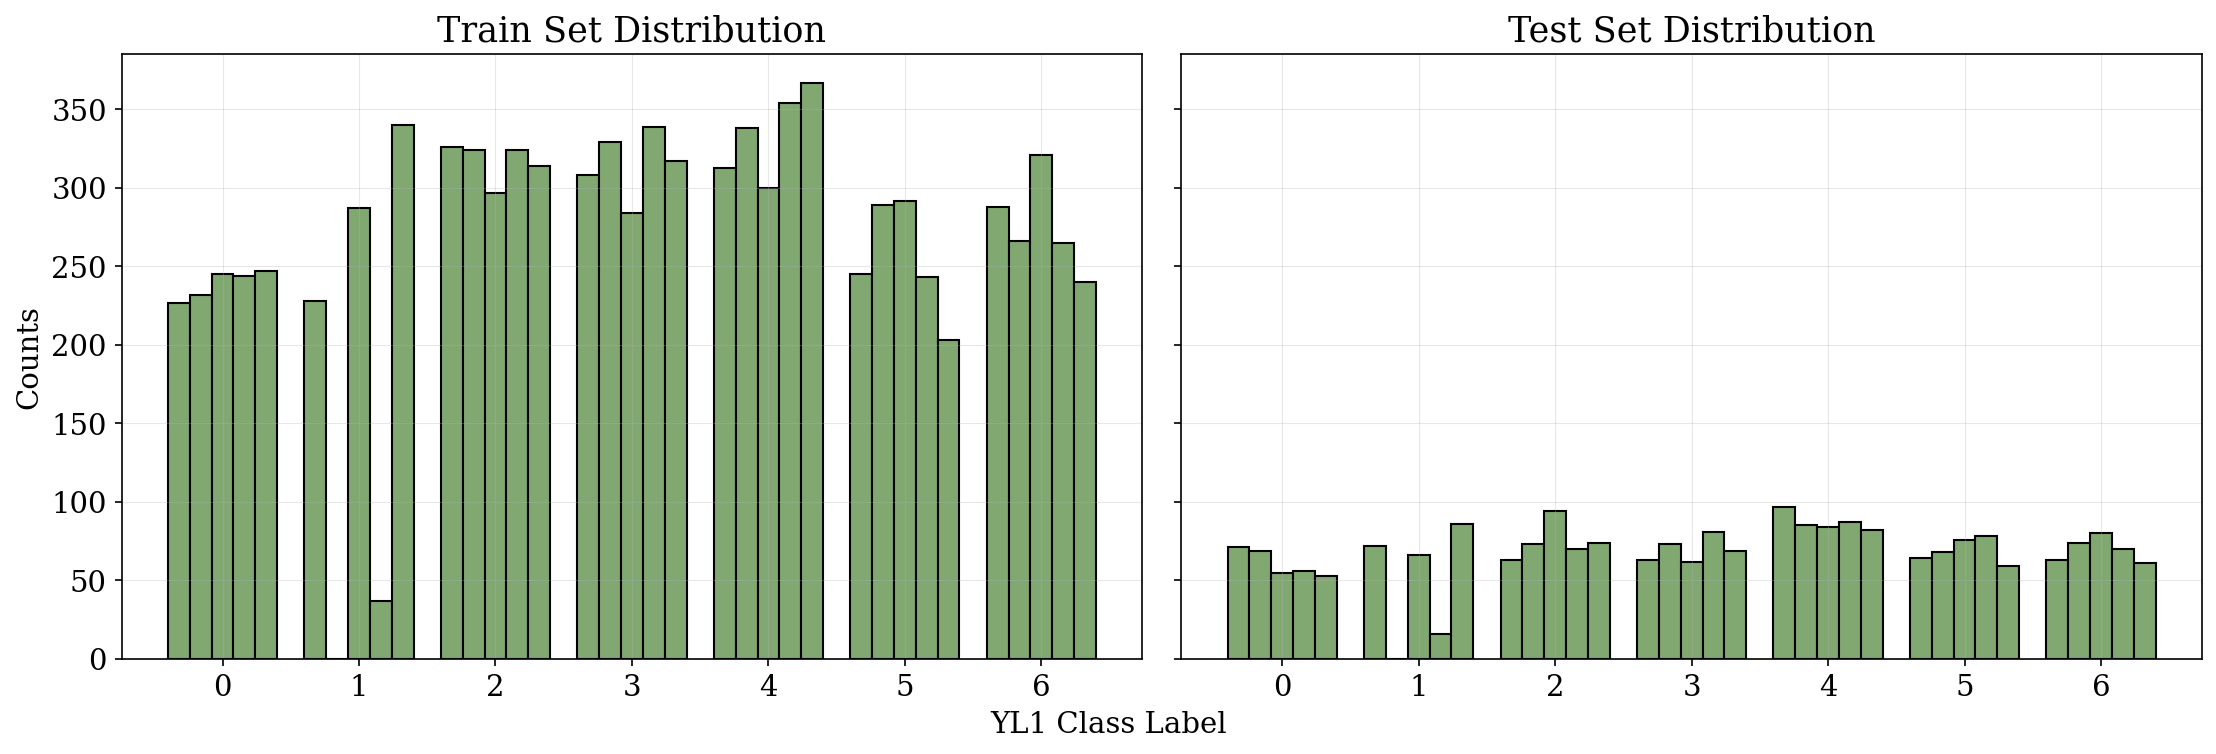

In [27]:
# Get all possible labels -> ASSUMES THEY ARE CONSECUTIVE INTEGERS FROM 0 TO N-1
parent_labels = np.arange(len(np.unique(WOS11967_dataset.YL1)))
child_labels = np.arange(len(np.unique(WOS11967_dataset.YL2)))

# Plot stats
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
plot_stats(train_stats, ax1, parent_labels=parent_labels, child_labels=child_labels)
plot_stats(test_stats, ax2, parent_labels=parent_labels, child_labels=child_labels)

# Labels
fig.text(0.5, 0, "YL1 Class Label", ha='center')
ax1.set_ylabel("Counts")

# Titles
ax1.set_title('Train Set Distribution')
ax2.set_title('Test Set Distribution')

plt.tight_layout()
plt.savefig(SAVEDIR + 'YL1_YL2_distribution.png')
plt.show()

# LSTM Model

## Implementing Class

In [119]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, device='cuda', nprocess=None):
        super().__init__()
        
        # device setup
        device = device.lower()
        assert device in ('cuda', 'cpu'), "Device must be 'cuda' or 'cpu'"
        use_cuda = (device == 'cuda') and torch.cuda.is_available()
        self.device = torch.device('cuda' if use_cuda else 'cpu')
        if not use_cuda:
            nprocess = multiprocessing.cpu_count() // 2 if nprocess is None else nprocess # defaults to half available cores
            msg = "CUDA not available, using CPU instead" if device == 'cuda' else "Using CPU"
            log.info(f"{msg} with nprocess={nprocess}")
        torch.set_num_threads(nprocess)
        self.to(self.device)
        self.nprocess = nprocess
        
        # based heavily on pytorch implementation (but changed notation)
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # training records (to add...)
        self.training_time = []
        self.training_loss = []
        self.validation_loss = []
        
        
        # Input gate
        self.W_xi = nn.Linear(input_size, hidden_size, bias=True) # input
        self.W_hi = nn.Linear(hidden_size, hidden_size, bias=True) # hidden
        
        # Forget gate
        self.W_xf = nn.Linear(input_size, hidden_size, bias=True) # input
        self.W_hf = nn.Linear(hidden_size, hidden_size, bias=True) # hidden
        
        # Candidate state
        self.W_xc = nn.Linear(input_size, hidden_size, bias=True) # input
        self.W_hc = nn.Linear(hidden_size, hidden_size, bias=True) # hidden

        # Output gate
        self.W_xo = nn.Linear(input_size, hidden_size, bias=True) # input
        self.W_ho = nn.Linear(hidden_size, hidden_size, bias=True) # hidden
        
        # Output layer
        self.W_hy = nn.Linear(hidden_size, output_size, bias=True)
        
        
    def forward(self, x, hidden=None): 
        """ 
        Args:
            x: (batch_size, seq_len, input_size)
            hidden: tuple of (h, c) each (batch_size, hidden_size)
        """
        batch_size, seq_len, _ = x.size()
        
        if hidden is None:
            h_t = torch.zeros(batch_size, self.hidden_size, device=x.device)
            cs_t = torch.zeros(batch_size, self.hidden_size, device=x.device) # cell state
        else:
            h_t, cs_t = hidden
            
        for t in range(seq_len):
            x_t = x[:, t, :]
        
            i_t = torch.sigmoid(self.W_xi(x_t) + self.W_hi(h_t))
            f_t = torch.sigmoid(self.W_xf(x_t) + self.W_hf(h_t))
            c_t = torch.tanh(self.W_xc(x_t) + self.W_hc(h_t))
            o_t = torch.sigmoid(self.W_xo(x_t) + self.W_ho(h_t))
        
            cs_t = f_t * cs_t + i_t * c_t # update cell state
            h_t = o_t * torch.tanh(cs_t) # update hidden state
             
        y = self.W_hy(h_t) # bias included in Linear layer
        return y, (h_t, cs_t)
    
    
    def fit(self, dataset, epochs=10, lr=1e-3, batch_size=32, shuffle=True, optimizer='Adam', val_train_split=0, store_records=False):
        """
        Can chose between optimizers: Adam, RMSprop, Adagrad
        """        
        log.info(" == LSTM Training Initialization ==")
        if val_train_split > 0:
            val_size = int(len(dataset) * val_train_split)
            train_size = len(dataset) - val_size
            train_set, val_set = random_split(dataset, [train_size, val_size])
            val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, collate_fn=LSTM.collate_fn)
            dataset = train_set  # for training loader
            log.info(f"Splitting dataset into {100*(1-val_train_split):.1f}% train and {100*val_train_split:.1f}% validation")
        else:
            val_loader = None
        train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=LSTM.collate_fn)
        log.info(f"Training on {len(train_loader.dataset)} samples in {len(train_loader)} batches of size {batch_size}")
        
        # getting optimizer
        if  optimizer == 'Adam':
            opt = torch.optim.Adam(self.parameters(), lr=lr)
        elif optimizer == 'RMSprop':
            opt = torch.optim.RMSprop(self.parameters(), lr=lr)
        elif optimizer == 'Adagrad':
            opt = torch.optim.Adagrad(self.parameters(), lr=lr)
        else:
            raise ValueError(f"Unsupported optimizer: {optimizer}")
        
        log.info(f"Using {optimizer} optimizer with learning rate {lr}")
        
        # defining loss function to be cross entropy
        loss_fn = nn.CrossEntropyLoss()

        # training loop!
        log.info(" == Training LSTM Model ==")
        for epoch in range(epochs):
            t = time.time()
            total_loss = 0
            for X, Y in train_loader:
                X, Y = X.to(self.device), Y.to(self.device)
                opt.zero_grad()
                logits, _ = self.forward(X)
                loss = loss_fn(logits, Y)
                loss.backward()
                opt.step()

                total_loss += loss.item()
                
            if val_loader is not None:
                val_loss = 0
                for val_X, val_Y in val_loader:
                    val_X, val_Y = val_X.to(self.device), val_Y.to(self.device)
                    val_logits, _ = self.forward(val_X)
                    v_loss = loss_fn(val_logits, val_Y)
                    val_loss += v_loss.item()
                avg_val_loss = val_loss / len(val_loader)
                    
            avg_loss = total_loss / len(train_loader)
            t_epoch = time.time() - t
            time_to_completion = t_epoch * (epochs - epoch - 1) / 60
            if store_records:
                self.training_time.append(t_epoch)
                self.training_loss.append(avg_loss)
                if val_loader is not None:
                    self.validation_loss.append(avg_val_loss)

            # if log.getEffectiveLevel() <= logging.INFO: # print only if log level is INFO. Doing this to avoid issues with logging output
            if val_loader is not None:
                log.info(f"Epoch {epoch+1}/{epochs}, Train Loss = {avg_loss:.4f}, Val Loss = {avg_val_loss:.4f} -- Time: {t_epoch:.2f}s == ~{time_to_completion:.2f}min remaining {' '*10}") 
            else:
                log.info(f"Epoch {epoch+1}/{epochs}, Train Loss = {avg_loss:.4f} -- Time: {t_epoch:.2f}s == ~{time_to_completion:.2f}min remaining {' '*10}") 
    
    
    @torch.no_grad() # disable gradient calculation for inference
    def predict(self, X):
        X = X.to(self.device)
        logits, _ = self.forward(X)
        return torch.argmax(logits, dim=1).cpu()

    def evaluate_acc(self, Y, Yhat):
        return np.mean(Y == Yhat)
    
    def evaluate_test_set(self, test_subset, batch_size=32):
        test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False, collate_fn=LSTM.collate_fn)
        y_true = []
        y_pred = []
        for X_batch, Y_batch in test_loader:
            X_batch = X_batch.to(self.device)
            Y_batch = Y_batch.to(self.device)
            Yhat_batch = self.predict(X_batch)
            y_true.extend(Y_batch.numpy())
            y_pred.extend(Yhat_batch.numpy())
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        acc = self.evaluate_acc(y_true, y_pred)
        return acc, y_true, y_pred
    
    def plot_training_loss(self):
        plt.plot(self.training_loss)
        plt.xlabel('Epoch')
        plt.ylabel('Training Loss')
        plt.title('Training Loss over Epochs')
        plt.show()
        
    @staticmethod
    def collate_fn(batch):
        sequences, labels = zip(*batch)
        padded = pad_sequence(sequences, batch_first=True)
        labels = torch.stack(labels)
        return padded, labels

## Training the model

In [118]:
lstm = LSTM(
    input_size=100,  # embedding size
    hidden_size=256,
    output_size=7,  # number of classes
    device='cpu',
    nprocess=4
    )

# run on WOS11967 dataset
lstm.fit(
    train_dataset, # subset of WOS11967_dataset
    epochs=15,
    lr=0.01,
    batch_size=64,
    shuffle=True,
    optimizer='Adam',
    store_records=True
)

15:13:25 - Using CPU with nprocess=4
15:13:25 -  == LSTM Training Initialization ==
15:13:25 - Training on 9573 samples in 150 batches of size 64
15:13:25 - Using Adam optimizer with learning rate 0.01
15:13:25 -  == Training LSTM Model ==
15:20:36 - Epoch 1/15, Train Loss = 1.6271 -- Time: 431.33s == ~100.64min remaining           


KeyboardInterrupt: 

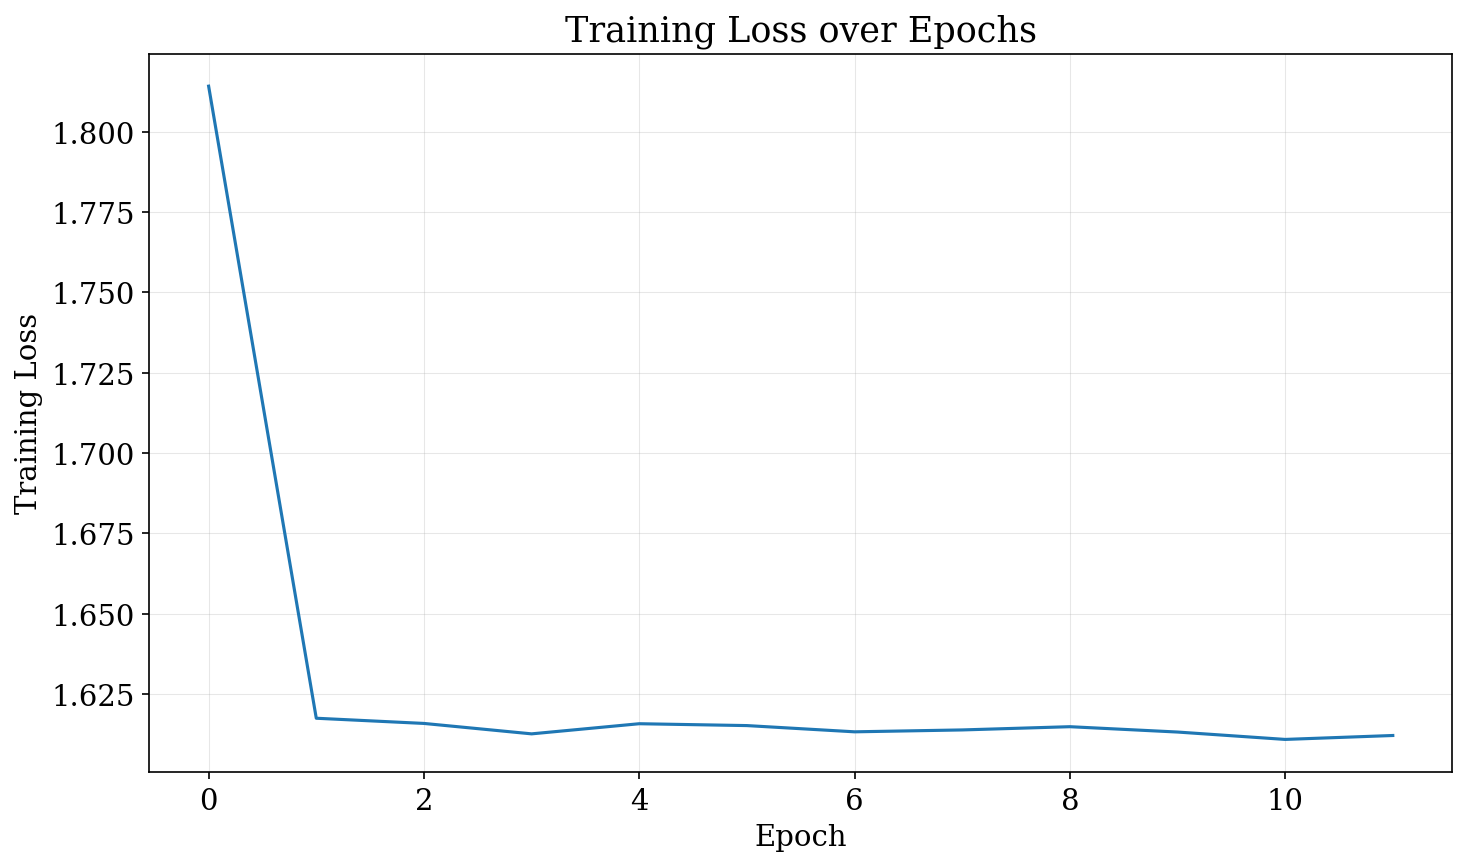

In [113]:
lstm.plot_training_loss()

In [114]:
lstm.evaluate_test_set(test_dataset)

(0.21261487050960734,
 array([0, 4, 0, ..., 4, 2, 3]),
 array([2, 2, 2, ..., 2, 2, 2]))

# BERT Model

In [103]:
# --- Select correct labels in datasets ---
if isinstance(train_dataset, torch.utils.data.Subset):
        indices = train_dataset.indices
        train_dataset = train_dataset.dataset # overwrite to get original (full) dataset
train_dataset.set_label('flat')

if isinstance(test_dataset, torch.utils.data.Subset):
        indices = test_dataset.indices
        test_dataset = test_dataset.dataset # overwrite to get original (full) dataset
test_dataset.set_label('flat')


# --- Load tokenizer & Model---
num_classes = 35  # flattened parent-child labels
device = 'cuda' if torch.cuda.is_available() else 'cpu'

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True, clean_up_tokenization_spaces=True)

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', num_labels=num_classes, output_attentions=True
).to(device)
model.config.output_attentions = True  # enable attention outputs
original_state_dict = {k: v.clone() for k, v in model.state_dict().items()} # save original state dict for resetting later

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [104]:
def bert_collate(batch):
    """
    Function to collate a batch of data for BERT model
    1. tokenize texts
    2. pad sequences to max length in batch
    3. return input_ids, attention_mask, labels
    """

    texts = [item[0] for item in batch]  # get texts
    labels = [item[1] for item in batch]  # use flattened labels

    enc = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=256,
        add_special_tokens=True,
        return_tensors="pt"
    )
    
    return enc["input_ids"], enc["attention_mask"], torch.tensor(labels)

## Fine Tuning

In [ ]:
# DO NOT RUN THIS CELL

# --- Fine-Tuning BERT Model ---
# ** Running this on mimi GPU with a python script **
learning_rates = [1e-5, 2e-5, 3e-5]
batch_sizes = [4, 8, 16]

# Dict to store all results
results = {}

for batch_size in batch_sizes:
    batch_size = int(batch_size)

    # Get tokenized loaders (with current batch size)
    train_loader_bert = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=bert_collate)
    test_loader_bert = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=bert_collate)

    # Loop over learning rates
    for lr in learning_rates:
        # Reset optimizer & model
        model.load_state_dict(original_state_dict)
        optimizer = AdamW(model.parameters(), lr=lr)
        torch.cuda.empty_cache()

        # Store losses and accuracies
        train_losses, test_losses, test_accuracies = [], [], []

        # Training loop (only a few epochs)
        num_epochs = 3
        for epoch in range(num_epochs):
            # Train
            model.train()
            total_loss = 0

            for batch in train_loader_bert:
                input_ids, attention_mask, labels = batch
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            avg_train_loss = total_loss / len(train_loader_bert)
            train_losses.append(avg_train_loss)

            # Evaluate on test set
            model.eval()
            total_test_loss = 0
            correct = 0
            total = 0
            with torch.no_grad():
                for batch in test_loader_bert:
                    input_ids, attention_mask, labels = batch
                    input_ids = input_ids.to(device)
                    attention_mask = attention_mask.to(device)
                    labels = labels.to(device)

                    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                    loss = outputs.loss
                    logits = outputs.logits
                    total_test_loss += loss.item()

                    preds = torch.argmax(logits, dim=1)
                    correct += (preds == labels).sum().item()
                    total += labels.size(0)

                avg_test_loss = total_test_loss / len(test_loader_bert)
                test_losses.append(avg_test_loss)
                test_acc = correct / total
                test_accuracies.append(test_acc)

                print(f"Epoch {epoch+1}/{num_epochs} -- "
                    f"Train Loss: {avg_train_loss:.4f}, "
                    f"Test Loss: {avg_test_loss:.4f}, "
                    f"Test Acc: {test_acc:.4f}")
            
        # Store results for this learning rate
        results[f"bs{batch_size}_lr{lr}"] = {
            "train_loss": train_losses,
            "test_loss": test_losses,
            "test_accuracy": test_accuracies
        }

        # Save model for this learning rate
        # torch.save(model.state_dict(), MODELDIR + f"bert_model_lr{lr}.pth")

# Save final results
with open(MODELDIR + f"bert_tuning_results_bs{batch_size}.pkl", "wb") as f:
    pickle.dump(results, f)

In [142]:
# Load tuning results
learning_rates = [1e-5, 2e-5, 3e-5]
batch_sizes = [4, 8, 16]
test_acc_all = []

for bs in batch_sizes:
    with open(MODELDIR + f"bert_tuning_results_bs{bs}.pkl", "rb") as f:
        tuning_results = pickle.load(f)

    # print results at last epoch (3)
    test_acc_current_lr = []
    for lr in tuning_results.keys():
        print(lr)
        train_loss = tuning_results[lr]["train_loss"][-1]
        test_loss = tuning_results[lr]["test_loss"][-1]
        test_acc = tuning_results[lr]["test_accuracy"][-1]

        test_acc_current_lr.append(test_acc)
        print(f"Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}, Test Acc = {test_acc:.4f}")
    
    test_acc_all.append(test_acc_current_lr)
test_acc_all = np.array(test_acc_all)  # shape (batch_sizes, learning_rates)

bs4_lr1e-05
Train Loss = 0.3089, Test Loss = 0.1826, Test Acc = 0.9549
bs4_lr2e-05
Train Loss = 0.2891, Test Loss = 0.1690, Test Acc = 0.9560
bs4_lr3e-05
Train Loss = 0.3184, Test Loss = 0.2019, Test Acc = 0.9480
bs8_lr1e-05
Train Loss = 0.3476, Test Loss = 0.1991, Test Acc = 0.9551
bs8_lr2e-05
Train Loss = 0.2847, Test Loss = 0.1723, Test Acc = 0.9561
bs8_lr3e-05
Train Loss = 0.2915, Test Loss = 0.1948, Test Acc = 0.9514
bs16_lr1e-05
Train Loss = 0.4461, Test Loss = 0.2926, Test Acc = 0.9337
bs16_lr2e-05
Train Loss = 0.3116, Test Loss = 0.1978, Test Acc = 0.9535
bs16_lr3e-05
Train Loss = 0.2900, Test Loss = 0.1753, Test Acc = 0.9554


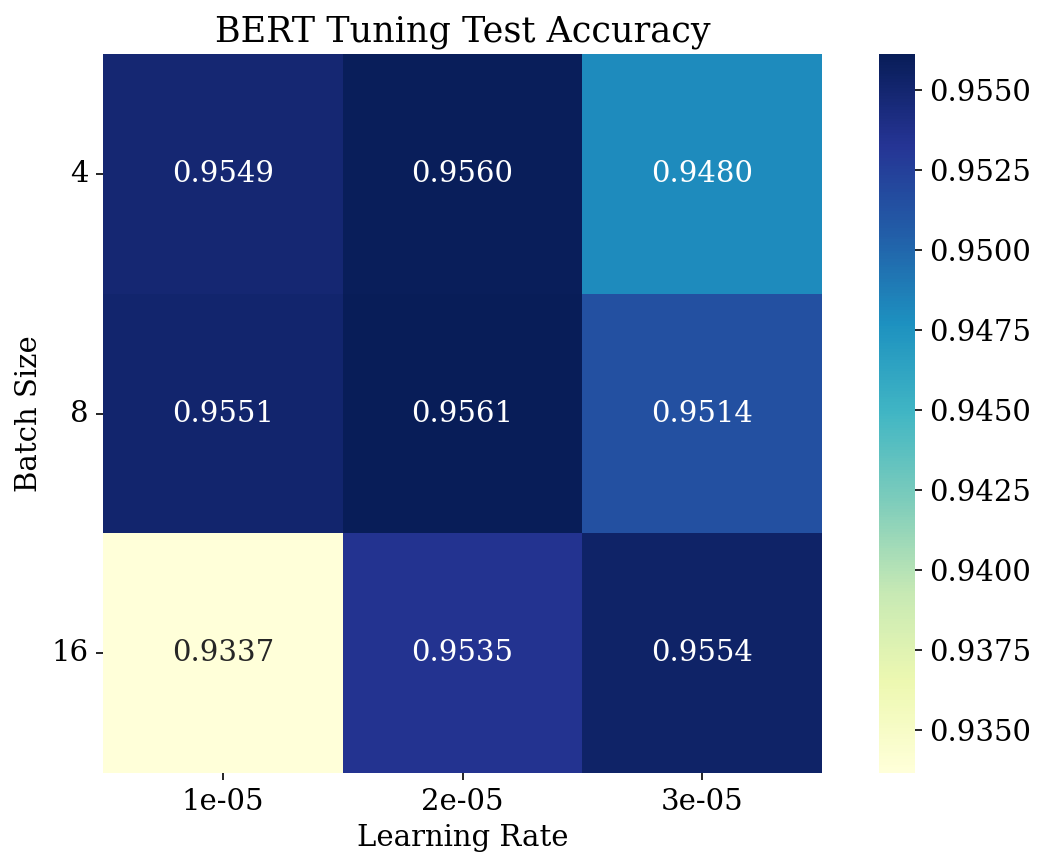

In [147]:
# Plot test accuracies for different learning rates and batch sizes
plt.figure(figsize=(8,6))
sns.heatmap(
    test_acc_all,
    annot=True,
    fmt=".4f",
    cmap="YlGnBu",
    xticklabels=[f"{lr:.0e}" for lr in learning_rates],
    yticklabels=batch_sizes,
    cbar=True,
    square=True
)

# Labels
plt.title("BERT Tuning Test Accuracy")
plt.xlabel("Learning Rate")
plt.ylabel("Batch Size")
plt.yticks(rotation=0)
plt.grid(False)

plt.tight_layout()
plt.savefig(SAVEDIR + 'bert_tuning_test_accuracy_heatmap.png')
plt.show()

## Full Training 

In [105]:
# Define optimal parameters
OPTIMAL_LR = 2e-5
OPTIMAL_BS = 8

# Other parameters
NUM_EPOCHS = 10
# ATTENTION_HEAD = 3  # pick an attention head to save

In [ ]:
# DO NOT RUN THIS CELL

# --- Training BERT Model ---
# ** Running this on mimi GPU with a python script **

# Get tokenized loaders (with current batch size)
train_loader_bert = DataLoader(train_dataset, batch_size=OPTIMAL_BS, shuffle=True, collate_fn=bert_collate)
test_loader_bert = DataLoader(test_dataset, batch_size=OPTIMAL_BS, shuffle=False, collate_fn=bert_collate)

# Reset optimizer & model (to prevent memory issues)
model.load_state_dict(original_state_dict)
optimizer = AdamW(model.parameters(), lr=OPTIMAL_LR)
torch.cuda.empty_cache()

# Store losses and accuracies at each epoch
train_losses, test_losses, test_accuracies = [], [], []
# Store attention data
saved_correct, saved_wrong = [], []


# Training loop
for epoch in range(NUM_EPOCHS):
    # -- Train --
    model.train()
    total_loss = 0

    for batch in train_loader_bert:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader_bert)
    train_losses.append(avg_train_loss)

    # -- Evaluate on test set --
    # Save attention for last epoch
    save_attention = epoch == NUM_EPOCHS - 1

    model.eval()
    total_test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in test_loader_bert:
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            total_test_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            # - Save attention for some samples -
            if save_attention and not saved_wrong:
                for i in range(len(labels)):  # go through instances in batch
                    # Check for misclassification
                    if preds[i] != labels[i] and len(saved_wrong) < 2:
                        # get all attention layers for this sample and head
                        head_attn_all_layers = [
                            # layer[i, ATTENTION_HEAD].cpu()  # matrix for this layer, saving one head
                            layer[i].cpu()  # saving all heads
                            for layer in outputs.attentions
                        ]
                        tokens = tokenizer.convert_ids_to_tokens(input_ids[i].cpu().tolist())
                        saved_wrong.append({
                            # "head": ATTENTION_HEAD,
                            "attentions": head_attn_all_layers,
                            "tokens": tokens,
                            "label": labels[i].item(),
                            "pred": preds[i].item()
                        })

                    # Check for correct classification
                    elif preds[i] == labels[i] and len(saved_correct) < 2:
                        head_attn_all_layers = [
                            # layer[i, ATTENTION_HEAD].cpu()
                            layer[i].cpu()  # saving all heads
                            for layer in outputs.attentions
                        ]
                        tokens = tokenizer.convert_ids_to_tokens(input_ids[i].cpu().tolist())
                        saved_correct.append({
                            # "head": ATTENTION_HEAD,
                            "attentions": head_attn_all_layers,
                            "tokens": tokens,
                            "label": labels[i].item(),
                            "pred": preds[i].item()
                        })
                    
                    # Break if we've saved enough
                    if len(saved_correct) == 2 and len(saved_wrong) == 2:
                        break

        # Compute epoch results
        avg_test_loss = total_test_loss / len(test_loader_bert)
        test_losses.append(avg_test_loss)
        test_acc = correct / total
        test_accuracies.append(test_acc)

        print(f"Epoch {epoch+1}/{NUM_EPOCHS} -- "
            f"Train Loss: {avg_train_loss:.4f}, "
            f"Test Loss: {avg_test_loss:.4f}, "
            f"Test Acc: {test_acc:.4f}")


# Store results
train_results = {
    "train_loss": train_losses,
    "test_loss": test_losses,
    "test_accuracy": test_accuracies
}

# Save final training results
with open(MODELDIR + f"bert_full_training_results.pkl", "wb") as f:
    pickle.dump(train_results, f)
with open(MODELDIR + "bert_attention_misclassified.pkl", "wb") as f:
    pickle.dump(saved_wrong, f)
with open(MODELDIR + "bert_attention_correctly_classified.pkl", "wb") as f:
    pickle.dump(saved_correct, f)

In [107]:
# Load training curves
with open(MODELDIR + f"bert_full_training_results.pkl", "rb") as f:
        results = pickle.load(f)

train_loss = results["train_loss"]
test_loss = results["test_loss"]
test_acc = results["test_accuracy"]

for i in range(len(train_loss)):
    print(f"Epoch {i+1}: Train Loss = {train_loss[i]:.4f}, Test Loss = {test_loss[i]:.4f}, Test Acc = {test_acc[i]:.4f}")

Epoch 1: Train Loss = 1.3067, Test Loss = 0.4638, Test Acc = 0.8866
Epoch 2: Train Loss = 0.4500, Test Loss = 0.2737, Test Acc = 0.9322
Epoch 3: Train Loss = 0.2903, Test Loss = 0.1845, Test Acc = 0.9527
Epoch 4: Train Loss = 0.1898, Test Loss = 0.1094, Test Acc = 0.9728
Epoch 5: Train Loss = 0.1315, Test Loss = 0.0666, Test Acc = 0.9854
Epoch 6: Train Loss = 0.1039, Test Loss = 0.0674, Test Acc = 0.9836
Epoch 7: Train Loss = 0.0807, Test Loss = 0.0556, Test Acc = 0.9870
Epoch 8: Train Loss = 0.0578, Test Loss = 0.0338, Test Acc = 0.9914
Epoch 9: Train Loss = 0.0486, Test Loss = 0.0299, Test Acc = 0.9925
Epoch 10: Train Loss = 0.0381, Test Loss = 0.0163, Test Acc = 0.9964


In [ ]:
# Load saved attention data for misclassified sample
with open(MODELDIR + "bert_attention_misclassified.pkl", "rb") as f:
    attention_misclass_data = pickle.load(f)  # list of misclassified samples

# Load saved attention data for correctly classified sample
with open(MODELDIR + "bert_attention_correctly_classified.pkl", "rb") as f:
    attention_correct_data = pickle.load(f)

# list element = dict with keys "attentions", "tokens", "label", "pred"
# attn matrix has shape (num_layers,num_heds,seq_len,seq_len) = (12,12,256,256)

## Plots

Training curves

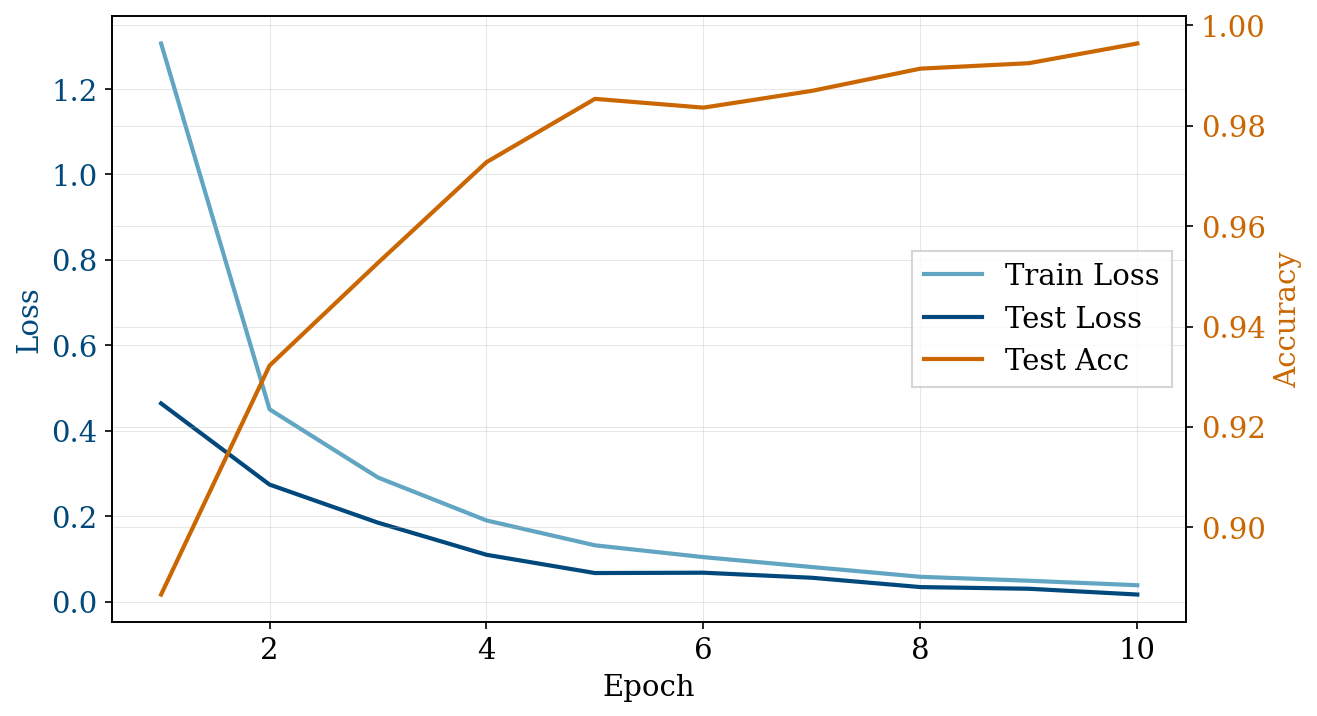

In [109]:
# --- Plot training curves ---
epochs = range(1, NUM_EPOCHS + 1)

fig, ax1 = plt.subplots(figsize=(9, 5))

# left axis - loss
color = "#01497c"
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(epochs, train_loss, marker='', lw = 2, color="#61a5c2", label='Train Loss')
ax1.plot(epochs, test_loss, marker='', lw = 2, color=color, label='Test Loss')
ax1.tick_params(axis='y', labelcolor=color)

# right axis - accuracy
color = '#ca6702'
ax2 = ax1.twinx()  # share x-axis
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(epochs, test_acc, marker='', lw = 2, color=color, label='Test Acc')
ax2.tick_params(axis='y', labelcolor=color)

plt.legend(loc='center right', handles = [ax1.lines[0], ax1.lines[1], ax2.lines[0]])
fig.tight_layout()
plt.savefig(os.path.join(SAVEDIR, 'bert_training_curve.png'))
plt.show()

Attention maps

In [ ]:
def plot_attention_map(attn_matrix, tokens, num_tokens=100, layer_idx=0, head_idx=0,
                       save_file=None, fig_title=None):
    """
    Plot the attention map given an attention matrix and tokens.

    Inputs:
    -------
    attn_matrix: 
        Full attention matrix, shape (num_layers, num_heads, seq_len, seq_len)
    tokens:
        List of tokens corresponding to the attention matrix
    num_tokens:
        Number of tokens to display (for large sequences)
    layer_idx:
        Selects the layer index from attn_matrix
    head_idx:
        Selects the head index from attn_matrix
    """

    # check token number
    num_tokens = None if num_tokens == 'all' else num_tokens
    ticks = np.arange(len(tokens)) if num_tokens == None else np.arange(num_tokens)


    # Get matrix to plot
    attn_matrix_plot = attn_matrix[layer_idx][head_idx,:num_tokens,:num_tokens]  # shape (num_tokens, num_tokens)

    # Plot
    plt.figure(figsize=(10, 8))
    title = f'Attention Map - Layer {layer_idx} Head {head_idx}' if fig_title is None else fig_title
    plt.title(title)
    
    plt.imshow(attn_matrix_plot, cmap='viridis')
    plt.colorbar(label='Attention Weight')
    
    plt.xticks(ticks=ticks, labels=tokens[:num_tokens], rotation=90)
    plt.yticks(ticks=ticks, labels=tokens[:num_tokens])

    plt.tight_layout()
    if save_file is not None:
        plt.savefig(SAVEDIR + save_file)
    plt.show()

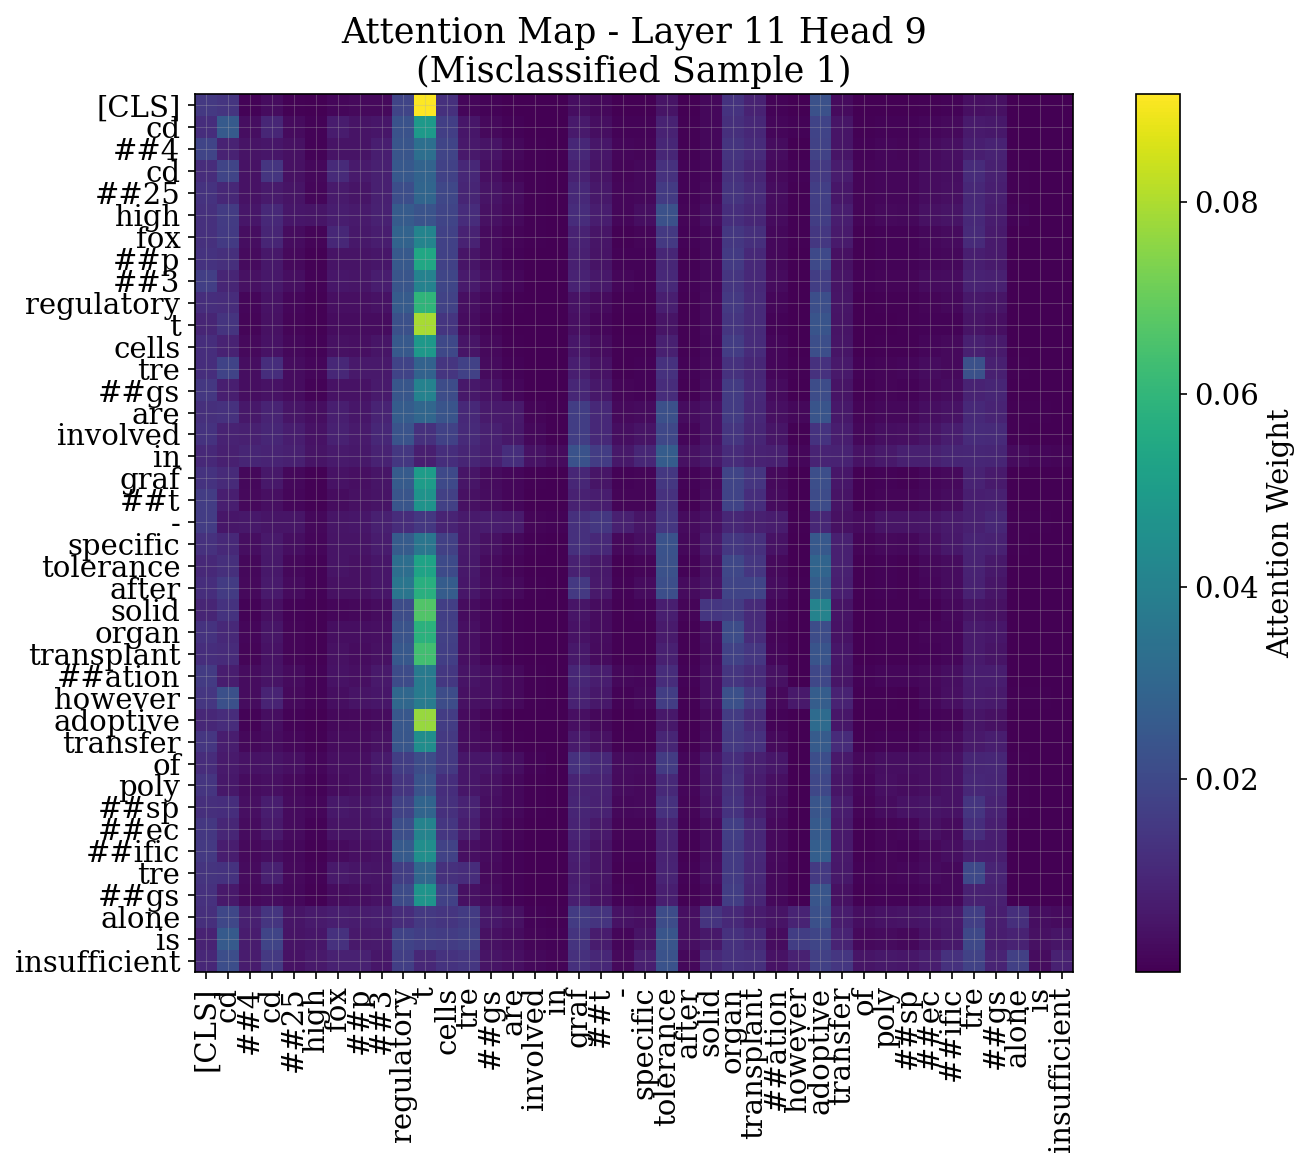

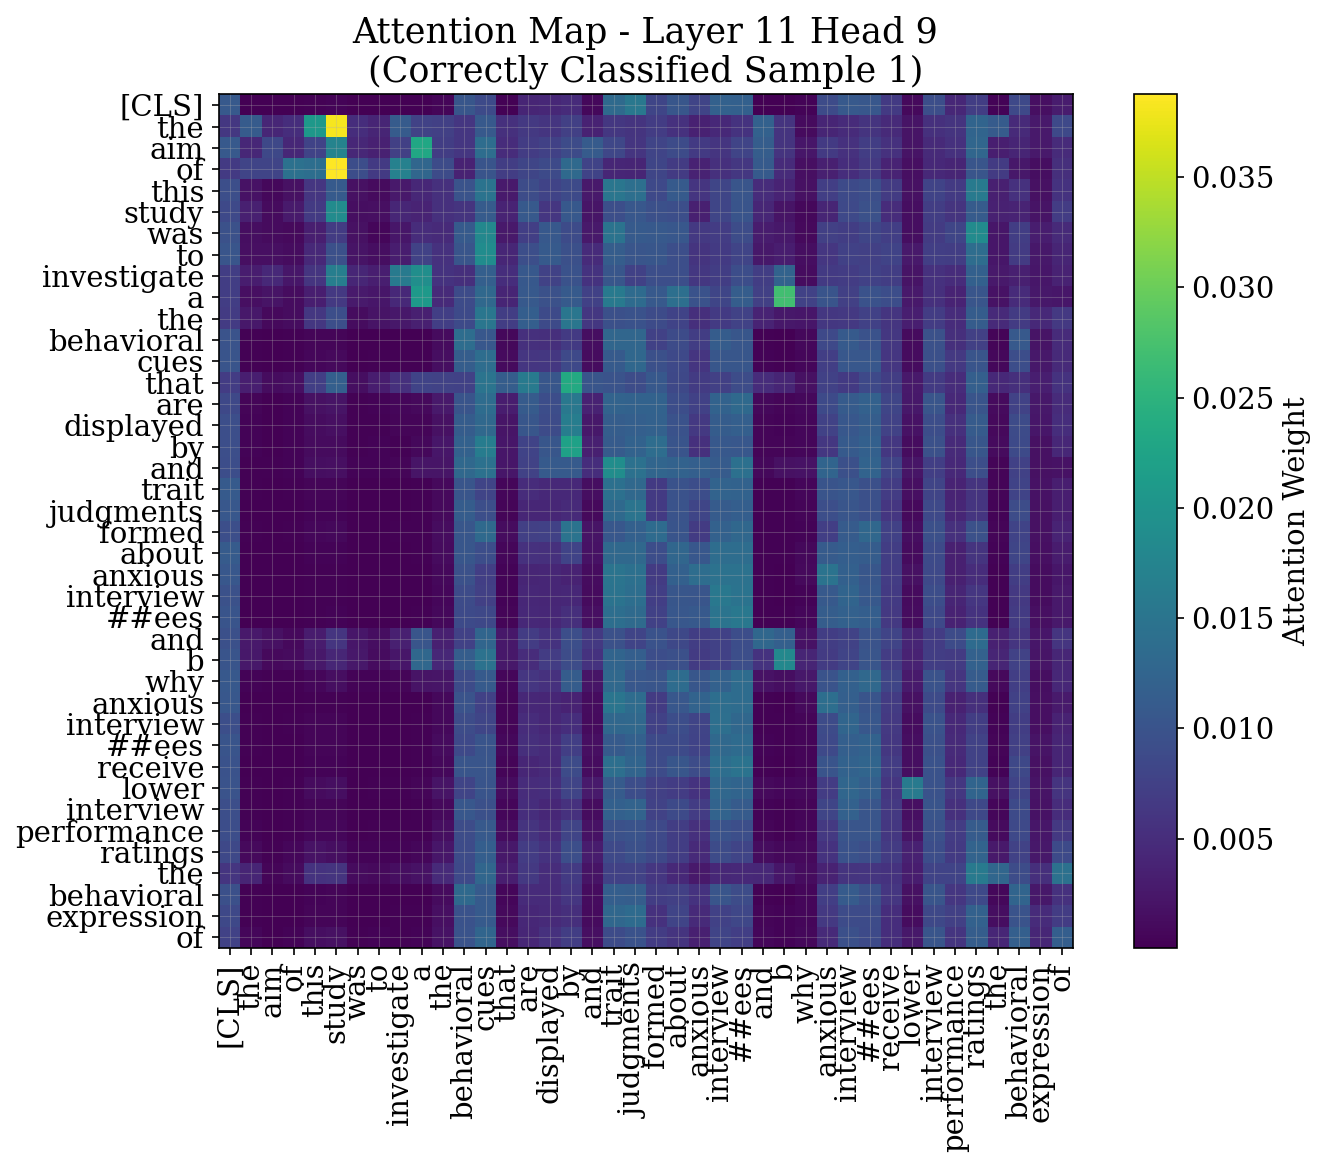

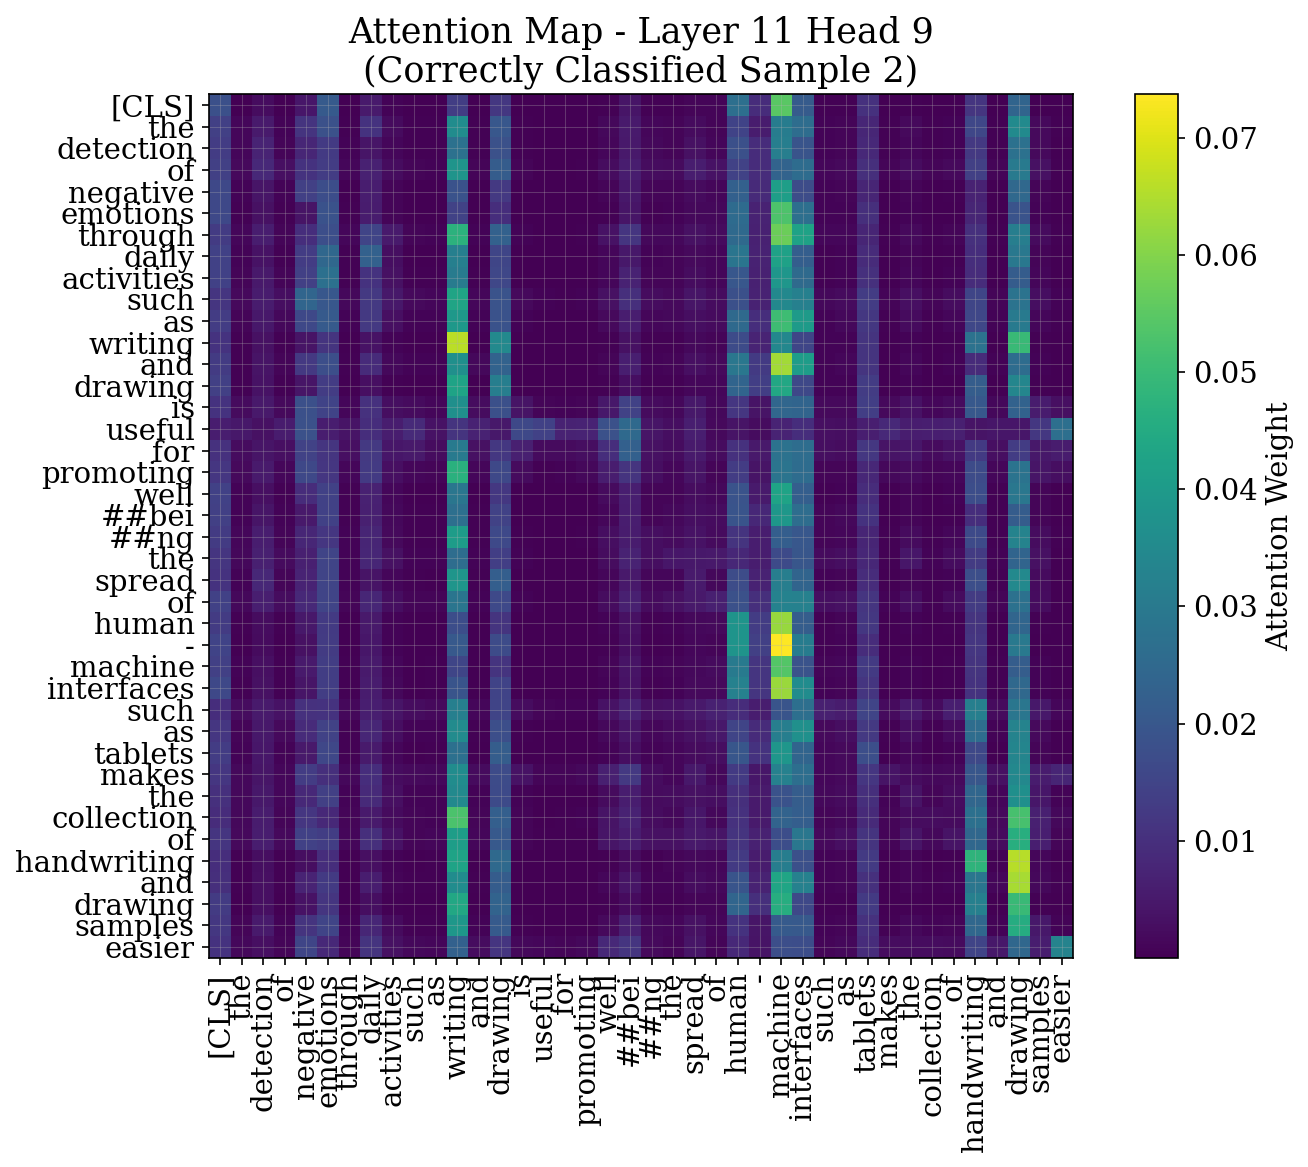

In [127]:
# --- Plot Attention Maps --- 
# Pick parameters
head_idx = 9
layer_idx = 11
num_tokens = 40  # use 'all' for the full matrix

# Misclassified samples
for i, data_dict in enumerate(attention_misclass_data):
    plot_attention_map(
        attn_matrix = data_dict["attentions"],
        tokens = data_dict["tokens"],
        num_tokens = num_tokens,
        layer_idx = layer_idx,
        head_idx = head_idx,
        save_file = f'bert_misclass_attn_map_head{head_idx}_layer{layer_idx}_{num_tokens}tokens_{i+1}.png',
        fig_title = f'Attention Map - Layer {layer_idx} Head {head_idx}\n(Misclassified Sample {i+1})'
        )

# Correctly classified samples
for i, data_dict in enumerate(attention_correct_data):
    plot_attention_map(
        attn_matrix = data_dict["attentions"],
        tokens = data_dict["tokens"],
        num_tokens = num_tokens,
        layer_idx = layer_idx,
        head_idx = head_idx,
        save_file = f'bert_correct_attn_map_head{head_idx}_layer{layer_idx}_{num_tokens}tokens_{i+1}.png',
        fig_title = f'Attention Map - Layer {layer_idx} Head {head_idx}\n(Correctly Classified Sample {i+1})'
        )